In [1]:
from imageai.Detection.Custom import CustomVideoObjectDetection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
video_number = 8 ## 1-8
pixel_length = 2.8 ## length of one pixel in mm
width = 1920
height = 1080

In [3]:
frame_list = []

def forFrame(frame_number, output_array, output_count):
  if len(output_array) == 0:
    frame_list.append({'name': 'bar', 'percentage_probability': 0.0, 'box_points': [np.nan, np.nan, np.nan, np.nan]})
  else:
    frame_list.append(output_array[0])


video_detector = CustomVideoObjectDetection()
video_detector.setModelTypeAsYOLOv3()
video_detector.setModelPath("bar/models/detection_model-ex-022--loss-0006.919.h5")
video_detector.setJsonPath("bar/json/detection_config.json")
video_detector.loadModel()

video_detector.detectObjectsFromVideo(input_file_path="videos/video_{}.mp4".format(video_number),
                                      output_file_path="videos/video_{}_d.mp4".format(video_number),
                                          frames_per_second=30,
                                          minimum_percentage_probability=30,
                                          log_progress=False,
                                          per_frame_function = forFrame)

'videos/video_8_d.mp4.avi'

In [4]:
df = pd.DataFrame([d['box_points'] for d in frame_list])
df.columns = ['left', 'top', 'right', 'bottom']
df.head()

,left,top,right,bottom
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Height (mm)')

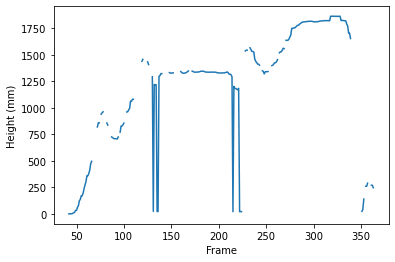

In [5]:
df['position'] = df[['bottom', 'top']].mean(axis=1)
df['position_mm'] = - (df['position'] - df.loc[df.first_valid_index(), 'position']) * pixel_length

plt.plot(df['position_mm'])
plt.xlabel('Frame')
plt.ylabel('Height (mm)')

In [6]:
def test_plausability(index, n_past):
    for n in range(1, n_past+1):
        speed = (df.loc[index, 'position_mm'] - df.loc[index-n, 'position_mm']) * 30 / 1000 / n
        if(abs(speed) > 10):
            print('Row {} implausible'.format(index))
            return False
    return True
    

for i in range(1, len(df)):
    if not test_plausability(i, min(i, 10)):
        df.loc[i, 'position_mm'] = np.nan
        print(i)

Row 131 implausible
131
Row 135 implausible
135
Row 136 implausible
136
Row 215 implausible
215
Row 222 implausible
222
Row 223 implausible
223
Row 224 implausible
224


In [7]:
null_rows = [index for index, row in df.iterrows() if row.isnull().any()]

null_epochs = []
epoch = []
for i in range(0, len(null_rows)):

    if (null_rows[i] - 1 == null_rows[i-1]):
        epoch.append(null_rows[i])
    else:
        null_epochs.append(epoch)
        epoch=[null_rows[i]]


null_epochs.append(epoch) ## append last epoch after loop
null_epochs.pop(0) ##drop first (empty) epoch
if(0 in null_epochs[0]):
    null_epochs.pop(0) ##drop first real epoch
if((len(df)-1) in null_epochs[-1]):
    null_epochs.pop(-1)

null_epochs   

[[67, 68],
 [70, 71],
 [75],
 [79, 80, 81],
 [84, 85, 86],
 [95],
 [101, 102],
 [111, 112, 113, 114, 115, 116, 117, 118],
 [121, 122],
 [124],
 [127, 128, 129],
 [131],
 [135, 136],
 [141, 142],
 [144, 145, 146, 147],
 [153, 154, 155, 156, 157, 158, 159],
 [169, 170, 171],
 [215],
 [222, 223, 224, 225, 226, 227],
 [231, 232],
 [244, 245],
 [253, 254, 255],
 [263],
 [270],
 [340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350],
 [354],
 [358, 359, 360]]

Text(0, 0.5, 'Height (mm)')

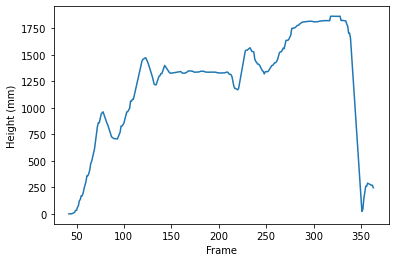

In [8]:
def interpolate_position(indices):
    l = len(indices)

    start = df.loc[indices[0]-1, 'position_mm']
    end = df.loc[indices[l-1]+1, 'position_mm']
    
    step = (end-start)/(l+1)

    new_positions = [start + i*step for i in range(1,l+1)]
    return(new_positions)
  

for epoch in null_epochs:
    df.loc[epoch, 'position_mm'] = interpolate_position(epoch)
    
plt.plot(df['position_mm'])
plt.xlabel('Frame')
plt.ylabel('Height (mm)')

Text(0, 0.5, 'Height (mm)')

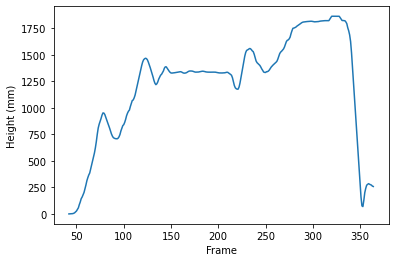

In [9]:
df['position_mm'] = df['position_mm'].rolling(3, min_periods=1).mean()

plt.plot(df['position_mm'])
plt.xlabel('Frame')
plt.ylabel('Height (mm)')

Text(0, 0.5, 'Height (mm)')

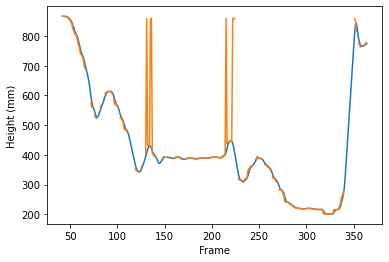

In [10]:
df['position_reversed'] = df.loc[df.first_valid_index(), 'position'] - df['position_mm'] / pixel_length

plt.plot(df['position_reversed'])
plt.plot(df['position'])
plt.xlabel('Frame')
plt.ylabel('Height (mm)')

Text(0, 0.5, 'Speed (m/s)')

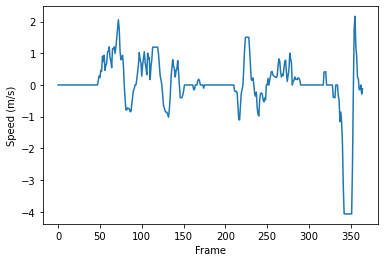

In [11]:
df['speed_ms'] = df['position_mm'].diff(1) * 30 / 1000
df.loc[(df['speed_ms'] < 0.1) & (df['speed_ms'] > -0.1), 'speed_ms'] = 0.0
df['speed_ms'].fillna(0.0, inplace=True)

plt.plot(df['speed_ms'])
plt.xlabel('Frame')
plt.ylabel('Speed (m/s)')

Text(0, 0.5, 'Acceleration (m/s²)')

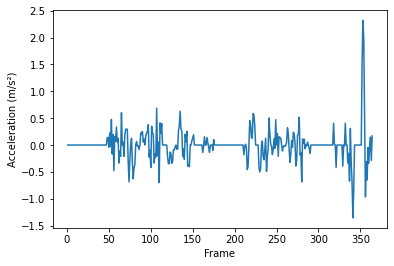

In [12]:
df['acceleration_ms2'] = df['speed_ms'].diff(1)

plt.plot(df['acceleration_ms2'])
plt.xlabel('Frame')
plt.ylabel('Acceleration (m/s²)')

In [15]:
cap = cv.VideoCapture('videos/video_{}.mp4'.format(video_number))
out = cv.VideoWriter('videos/video_{}_f.mp4'.format(video_number), cv.VideoWriter_fourcc(*'MP4V'), 30.0, (width,height))

while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame_number = int(cap.get(cv.CAP_PROP_POS_FRAMES)) - 1
    pos = df.loc[frame_number]
    
    if(pos[0] == pos[0]):
        frame = cv.rectangle(frame, (int(pos[0]), int(pos[1])), (int(pos[2]), int(pos[3])), (255,255,255), 2)
    
    ### height marker
    if(pos[5] == pos[5]):
        frame = cv.line(frame, (0,int(pos[6])),(50,int(pos[6])),(255,255,255),3)
        frame = cv.putText(frame, str(int(pos[5]) + 225), (10, int(pos[6] - 20)), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
        frame = cv.putText(frame, 'mm', (10, int(pos[6] + 40)), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
    
    out.write(frame)
    #cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
out.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
